In [39]:
from numba import njit, prange
from math import sin
import numpy as np
import xarray as xr
import random
import time

h = 6.62607004e-34
e = 1.6021765e-19
hbar = h / (2 * np.pi)

# Shapiro maps

## Code

In [45]:
def RSJ_SQUID(I_dc: np.array, 
           I_rf: np.array,
           f_rf: float, 
           Rj: float, 
           Ic: float, 
           alpha :float = 0.,
           beta :float = 1.,
           gamma :float = 0.,
           rho :float = 0,
           phi_ext :float = 0.5,
           sigma: float = 0.5, 
           n_periods: int = 100, 
           pts_period: int = 1000,
           simulation_type = 'I-V') -> xr.DataArray:

    t0 = hbar / ( 2 * e * Ic * Rj )
    eta = 2 * np.pi * f_rf * t0

    # Time step of the t vs phi evolution
    dt = 2 * np.pi / ( eta * pts_period )
    n_total = n_periods * pts_period

    params = {'f_rf': f_rf, 'Rj': Rj, 'Ic': Ic, 'sigma': sigma, 'n_periods': n_periods, 'pts_period': pts_period}
    
    @njit
    def CPR(phi):
        """ Return CPR of the junction """
        
        return sin(phi)

    @njit
    def Dphi(phi, t, i_dc, i_rf):
        """ Return derivative of phases """
        j = (phi[0] - phi[1] - 2*np.pi*phi_ext)/(np.pi*beta) - 0.5 * gamma * i_dc

        dphi1 = (0.5 * i_dc + 0.5 * i_rf * sin(eta*t) - j - ( 1 - alpha ) * CPR(phi[0]))/(1 - rho)
        dphi2 = (0.5 * i_dc + 0.5 * i_rf * sin(eta*t) + j - ( 1 + alpha ) * CPR(phi[1]))/(1 + rho)
        return np.array([dphi1, dphi2])

    @njit
    def RK2(phi, t, i_dc, i_rf):
        """ 4th order Runge-Kutta method """

        F1 = Dphi(phi, t, i_dc, i_rf)
        F2 = Dphi(phi + 0.5 * dt * F1, t + 0.5 * dt, i_dc, i_rf)
        F3 = Dphi(phi + 0.5 * dt * F2, t + 0.5 * dt, i_dc, i_rf)
        F4 = Dphi(phi + dt * F3, t + dt, i_dc, i_rf)

        phi_out = phi + dt/6. * (F1 + F4 + 2.*(F2 + F3))
        t_out = t + dt

        return phi_out, t_out

    @njit
    def calculate(i_dc, i_rf, phi0):
        phi, t = np.zeros((n_total,2)), np.zeros(n_total)
        phi[0], t[0] = phi0, 0

        for n in range(n_total - 1):
            noise = random.gauss(0, sigma)
            phi[n+1], t[n+1] = RK2(phi[n], t[n], i_dc + noise, i_rf)

        return (phi[-1, 0] - phi[0, 0])/(t[-1]-t[0]), np.array([phi[-1, 0], phi[-1, 1]])

    @njit(parallel=True)
    def loop(V, I_dc, I_rf):

        for n1 in prange(len(I_rf)):
            V[0, n1], phi0 = calculate(I_dc[0], I_rf[n1], phi0 = np.array([0,0]))

            for n2 in range(len(I_dc)):
                V[n2, n1], phi0  = calculate(I_dc[n2], I_rf[n1], phi0 = phi0)

        return V * Ic * Rj / ( h * f_rf / ( 2 * e ) )

    """ Run the simulation """
    start = time.time()

    V = np.zeros((len(I_dc), len(I_rf)))
    V = xr.DataArray(loop(V, I_dc, I_rf), 
                    coords = (('i_dc', I_dc, {'long_name': 'DC current', 'units':'$I_c$'}), 
                               ('i_rf', 20 * np.log10(I_rf), {'long_name': 'RF current', 'units':'dB'})),
                    attrs = {'long_name': 'Voltage drop', 
                              'units': '$hf/2e$',
                              'params': params})


    elapsed_time = time.time() - start
    print(f'Simulation took: {elapsed_time:.1f} s')
    
    return V

## Examples

### Standard shapiro steps in a SQUID

Simulation took: 707.7 s


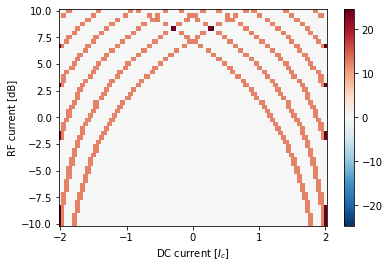

In [47]:
I_dc = np.linspace(-2,2, 100)
I_rf = np.logspace(-0.5,0.5, 50)
V = RSJ_SQUID(I_dc, I_rf, f_rf = 1.75e9, Rj = 500, Ic = 50e-9, sigma = 0., alpha=0., beta=0.01, gamma=0, rho=0, phi_ext=0.)

V.transpose().differentiate('i_dc').plot()

### Fractional shapiro steps at $\Phi_{ext} = 0$

Simulation took: 696.2 s


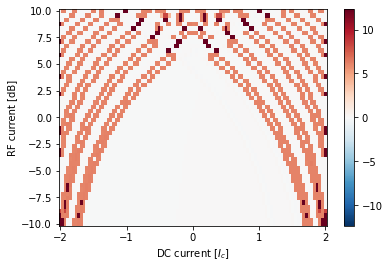

In [46]:
I_dc = np.linspace(-2,2, 100)
I_rf = np.logspace(-0.5,0.5, 50)
V = RSJ_SQUID(I_dc, I_rf, f_rf = 1.75e9, Rj = 500, Ic = 50e-9, sigma = 0., alpha=0.15, beta=10, gamma=0, rho=0, phi_ext=0.)

V.transpose().differentiate('i_dc').plot()

# Flux sweeps

## Code

In [44]:
def RSJ_SQUID(I_dc: np.array, 
           Phi_ext: np.array,
           i_rf: float,
           f_rf: float, 
           Rj: float, 
           Ic: float, 
           alpha :float = 0.,
           beta :float = 1.,
           gamma :float = 0.,
           rho :float = 0,
           sigma: float = 0.5, 
           n_periods: int = 100, 
           pts_period: int = 1000) -> xr.DataArray:

    t0 = hbar / ( 2 * e * Ic * Rj )
    eta = 2 * np.pi * f_rf * t0

    # Time step of the t vs phi evolution
    dt = 2 * np.pi / ( eta * pts_period )
    n_total = n_periods * pts_period

    params = {'f_rf': f_rf, 'Rj': Rj, 'Ic': Ic, 'sigma': sigma, 'n_periods': n_periods, 'pts_period': pts_period}
    
    @njit
    def CPR(phi):
        """ Return CPR of the junction """
        
        return sin(phi)

    @njit
    def Dphi(phi, t, i_dc, phi_ext):
        """ Return derivative of phases """
        j = (phi[0] - phi[1] - 2*np.pi*phi_ext)/(np.pi*beta) - 0.5 * gamma * i_dc

        dphi1 = (0.5 * i_dc + 0.5 * i_rf * sin(eta*t) - j - ( 1 - alpha ) * CPR(phi[0]))/(1 - rho)
        dphi2 = (0.5 * i_dc + 0.5 * i_rf * sin(eta*t) + j - ( 1 + alpha ) * CPR(phi[1]))/(1 + rho)
        return np.array([dphi1, dphi2])

    @njit
    def RK2(phi, t, i_dc, phi_ext):
        """ 4th order Runge-Kutta method """

        F1 = Dphi(phi, t, i_dc, phi_ext)
        F2 = Dphi(phi + 0.5 * dt * F1, t + 0.5 * dt, i_dc, phi_ext)
        F3 = Dphi(phi + 0.5 * dt * F2, t + 0.5 * dt, i_dc, phi_ext)
        F4 = Dphi(phi + dt * F3, t + dt, i_dc, phi_ext)

        phi_out = phi + dt/6. * (F1 + F4 + 2.*(F2 + F3))
        t_out = t + dt

        return phi_out, t_out

    @njit
    def calculate(i_dc, phi_ext, phi0):
        phi, t = np.zeros((n_total,2)), np.zeros(n_total)
        phi[0], t[0] = phi0, 0

        for n in range(n_total - 1):
            noise = random.gauss(0,sigma)
            phi[n+1], t[n+1] = RK2(phi[n], t[n], i_dc + noise, phi_ext)

        return (phi[-1, 0] - phi[0, 0])/(t[-1]-t[0]), np.array([phi[-1, 0], phi[-1, 1]])

    @njit(parallel=True)
    def loop(V, I_dc, Phi_ext):

        for n1 in prange(len(Phi_ext)):
            V[0, n1], phi0 = calculate(I_dc[0], Phi_ext[n1], phi0 = np.array([0,0]))

            for n2 in range(len(I_dc)):
                V[n2, n1], phi0  = calculate(I_dc[n2], Phi_ext[n1], phi0 = phi0)

        return V * Ic * Rj


    """ Run the simulation """
    start = time.time()

    V = np.zeros((len(I_dc), len(Phi_ext)))
    V = xr.DataArray(loop(V, I_dc, Phi_ext), 
                    coords = (('i_dc', I_dc, {'long_name': 'DC current', 'units':'$I_c$'}), 
                               ('phi_ext', Phi_ext, {'long_name': 'Magnetic flux', 'units':'$\Phi_0$'})),
                    attrs = {'long_name': 'Voltage drop', 
                              'units': 'V',
                              'params': params})


    elapsed_time = time.time() - start
    
    print(f'Simulation took: {elapsed_time:.1f} s')
    
    return V

## Examples

### Symmetric SQUID with neglible inductance $ \alpha = 0 $, $\beta = 0$

In [10]:
I_dc = np.linspace(-3,3, 100)
Phi_ext = np.linspace(-0.75,0.75,50)
V = RSJ_SQUID(I_dc, Phi_ext, i_rf=0, f_rf = 1.75e9, Rj = 500, Ic = 50e-9, sigma = 0., alpha=0, beta=0.01, gamma=0, rho=0, )

Simulation took: 705.6 s


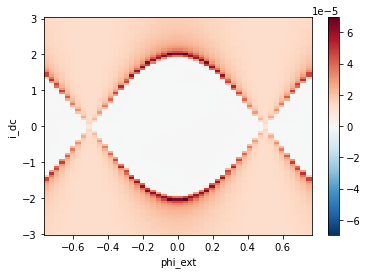

In [11]:
V.differentiate('i_dc').plot()

### Symmetric SQUID with finite inductance $ \alpha = 0 $, $\beta \simeq 1$

For finite $\beta$, the critical current can't be totally suppressed. In this case, it goes from $2 I_c$ at $\Phi_{ext} = 0$ to $I_c$ at $\Phi_{ext} = 0.5 \Phi_0$.

In [8]:
I_dc = np.linspace(-3,3, 100)
Phi_ext = np.linspace(-0.75,0.75,50)
V = RSJ_SQUID(I_dc, Phi_ext, i_rf=0, f_rf = 1.75e9, Rj = 500, Ic = 50e-9, sigma = 0., alpha=0, beta=1, gamma=0, rho=0, )

Simulation took: 705.2 s


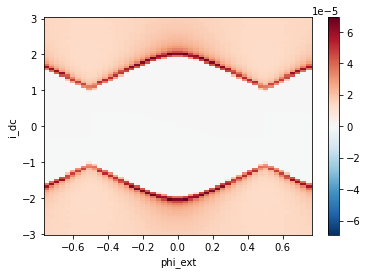

In [9]:
V.differentiate('i_dc').plot()

### Asymmetric SQUID with finite inductance  $ \alpha = 0.5 $, $\beta \simeq 1$

For finite $\alpha$ and $\beta$, the critical current can't be totally suppressed. 

In [15]:
I_dc = np.linspace(-3,3, 100)
Phi_ext = np.linspace(-0.75,0.75,50)
V = RSJ_SQUID(I_dc, Phi_ext, i_rf=0, f_rf = 1.75e9, Rj = 500, Ic = 50e-9, sigma = 0., alpha=0.5, beta=1, gamma=0, rho=0, )

Simulation took: 702.1 s


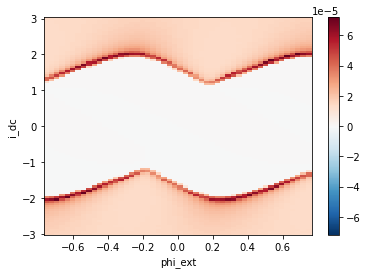

In [16]:
V.differentiate('i_dc').plot()